# Imports

In [1]:
import pandas as pd
import numpy as np
from lightgbm import plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
filterwarnings('ignore')
from ipynb.fs.full.helper import get_linear_reg, get_quadratic_reg, plot_confusion_matrix, fit_model, eval_pred, eval_model

# Load Data

In [2]:
df = pd.read_csv('../data/train_set.csv', parse_dates=['timestamp'])

The goal of this model is to predict the label for each patient. 

In [3]:
MEASUREMENTS = ['measurement_x', 'measurement_y', 'measurement_z']

Measurements may be KPIs such as oxygen saturation, ejection fraction from the left ventricle or an overall score of the patient status based on other indicators. \
Classes may be 0: low health risk, 1: medium health risk, 2: high health risk.

In [4]:
features = [df.groupby('patient_id')[measure].apply(list) for measure in MEASUREMENTS]
label = df.groupby('patient_id')['label'].first()
df_patients = pd.concat(features, axis=1).reset_index()
df_patients = pd.concat([df_patients, label], axis=1)

As patients have 1 label, I group their measurements.

# Feature Engineering

## Statistical Measures by Patient

I created features to reflect the data points variability and central tendency.

In [5]:
for measure in MEASUREMENTS:
    df_patients[f'{measure}_std'] = df_patients[measure].apply(np.std)
    df_patients[f'{measure}_mean'] = df_patients[measure].apply(np.mean)    
    df_patients[f'{measure}_median'] = df_patients[measure].apply(np.median)

## Linear Regression Measures by Patient

I built a linear regression for each feature, used the slope to represent the data variation (+ or -) for each measurement and the correlation coefficient to understand measurements relationship.

In [6]:
for measure in MEASUREMENTS:
    df_patients[[f'{measure}_lr_slope', f'{measure}_lr_corr']] = df_patients.apply(lambda row: get_linear_reg(row[measure]), axis=1, result_type="expand")

## Quadratic Regression Measures by Patient

I create a feature using the coefficients of the quadratic regression function to input data about the shape and variation of the data points

In [7]:
for measure in MEASUREMENTS:
    df_patients[[f'{measure}_quad_a', f'{measure}_quad_b']] = df_patients.apply(lambda row: get_quadratic_reg(row[measure]), axis=1, result_type="expand")

The features I added can provide information for patient with few records.

# Model

In [8]:
model_df = df_patients.drop(['patient_id', 'measurement_x', 'measurement_y', 'measurement_z'], axis=1)

Split the set to validate the training and make predictions

In [9]:
X, y = model_df.drop('label', axis=1), model_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

The model is a LightGBM classifier, trains fast and can deal with NaN values.

In [17]:
model = fit_model(X_train, y_train, X_eval, y_eval, verbose=False)

TypeError: fit_model() got an unexpected keyword argument 'verbose'

# Evaluation

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3523
           1       1.00      0.99      1.00      1243
           2       1.00      1.00      1.00       376

    accuracy                           1.00      5142
   macro avg       1.00      1.00      1.00      5142
weighted avg       1.00      1.00      1.00      5142



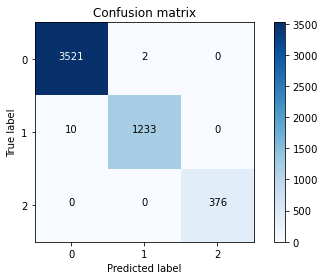

In [11]:
eval_pred(model, X_test, y_test)

The model predicts the class well but the thresholds can be modified to reduce errors

In [12]:
eval_model(model, X, y)

Cross-Validation splits score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

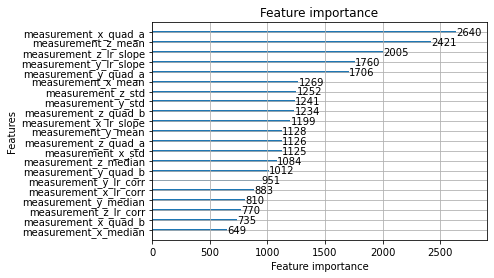

In [13]:
plot_importance(model)

# Retrain with all the data 

In [14]:
X, y = model_df.drop('label', axis=1), model_df['label']
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, stratify=y)

In [15]:
model = fit_model(X_train, y_train, X_eval, y_eval)

[1]	valid_0's multi_logloss: 0.718448
[2]	valid_0's multi_logloss: 0.661703
[3]	valid_0's multi_logloss: 0.613591
[4]	valid_0's multi_logloss: 0.572062
[5]	valid_0's multi_logloss: 0.53528
[6]	valid_0's multi_logloss: 0.502267
[7]	valid_0's multi_logloss: 0.47235
[8]	valid_0's multi_logloss: 0.445749
[9]	valid_0's multi_logloss: 0.421386
[10]	valid_0's multi_logloss: 0.399061
[11]	valid_0's multi_logloss: 0.37859
[12]	valid_0's multi_logloss: 0.360053
[13]	valid_0's multi_logloss: 0.342872
[14]	valid_0's multi_logloss: 0.327438
[15]	valid_0's multi_logloss: 0.312507
[16]	valid_0's multi_logloss: 0.298357
[17]	valid_0's multi_logloss: 0.28504
[18]	valid_0's multi_logloss: 0.272475
[19]	valid_0's multi_logloss: 0.261024
[20]	valid_0's multi_logloss: 0.250097
[21]	valid_0's multi_logloss: 0.239908
[22]	valid_0's multi_logloss: 0.2302
[23]	valid_0's multi_logloss: 0.221372
[24]	valid_0's multi_logloss: 0.212597
[25]	valid_0's multi_logloss: 0.204451
[26]	valid_0's multi_logloss: 0.196955
[

# Save Model

In [16]:
model.booster_.save_model('../artifacts/model.txt')